# Naive Feature Visualization

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision.transforms.functional import resize

device = 'cpu'
torch.manual_seed(0)

# common function to show results of different visualizations
def show_result(_imgs, _thresholds):
    fig, axs = plt.subplots(1, len(_imgs), figsize=(15, 3))
    for i, img in enumerate(_imgs):
        # Resize image to double its size
        img_resized = resize(torch.from_numpy(img), [int(image_size*1.5), int(image_size*1.5)])
        # in InceptionV1 the dimensions of the resulting image are (channels, height, width)
        # matplotlib expects (height, width, channels)
        img_resized = img_resized.permute(1, 2, 0).numpy()
        
        # display the image on a specific axis
        axs[i].imshow(img_resized)
        # disable x/y number grid
        axs[i].axis('off')
        axs[i].set_title(f'Iteration {_thresholds[i]}')
    
    plt.tight_layout() # makes arrangement of the images a bit nicer
    plt.show()

In [3]:
import IPython
import base64
import io
from IPython.display import HTML
from PIL import Image
import scipy.ndimage as nd

def serialize_array(arr, fmt='png'):
    img = Image.fromarray(np.uint8(arr * 255))
    buffer = io.BytesIO()
    img.save(buffer, format=fmt)
    return buffer.getvalue()

def image_url(array, fmt='png'):
    image_data = serialize_array(array, fmt=fmt)
    base64_byte_string = base64.b64encode(image_data).decode('ascii')
    return "data:image/" + fmt.upper() + ";base64," + base64_byte_string

def show_result_html(_imgs, _thresholds):
    s = '<div style="display: flex; flex-direction: row;">'
    for i, img in enumerate(_imgs):
        img_resized = nd.zoom(img, [1,2,2], order=0)
        img_resized = torch.from_numpy(img_resized).permute(1, 2, 0).numpy()
        label = f'Iteration {_thresholds[i]}'
        img_html = f'<img src="{image_url(img_resized)}" style="image-rendering: pixelated; image-rendering: crisp-edges;">'
        s += f"""<div style="margin-right:10px; margin-top: 4px;">
                    {label} <br/>
                    {img_html}
                 </div>"""
    s += "</div>"
    IPython.display.display(IPython.display.HTML(s))

In [4]:
import torch.nn as nn

def pixel_image(shape, sd=0.01):
    return np.random.normal(size=shape, scale=sd).astype(np.float32)

class ParameterizedImage(nn.Module):
    def __init__(self, w, h=None, batch=1, sd=0.01, channels=3):
        super().__init__()
        h = h or w
        shape = [batch, channels, h, w]
        init_val = pixel_image(shape, sd=sd)
        self.param = nn.Parameter(torch.tensor(init_val))

    def forward(self):
        return torch.sigmoid(self.param)

In [162]:
import torchvision.models as models

# Load pre-trained Inception v1 (GoogLeNet in PyTorch)
model = models.googlenet(pretrained=True).eval()
model.to(device)

# Set up the layer we want to visualize
# In this case, we'll use the equivalent of "mixed4b_pre_relu:452" in InceptionV1
# This corresponds to the 4th Inception module, b branch, before ReLU
target_layer = model.inception4b
target_channel = 452 # just for info
local_target_channel = 4

# Parameters
image_size = 64
learning_rate = 0.05
num_iterations = 2560
thresholds = [1, 32, 128, 256, 2048, 2560]


activation = {}
def get_activation():
    def hook(module, input, output):
        activation['target'] = output
    return hook

target_layer.branch4[1].conv.register_forward_hook(get_activation())
# target_layer.register_forward_hook(get_activation()) # REGISTERING LIKE THIS WILL NOT WORK -- IT REGISTERS POST-RELU SHIT!!!

input_image = torch.randn(1, 3, 64, 64)

with torch.no_grad():
    _ = model(input_image)

# Get the 452nd channel (remember, Python uses 0-based indexing)
channel_452 = activation['target'][:, local_target_channel]

print(f"Shape of activation for channel 452: {channel_452.shape}")
print(f"Pre-ReLU activation for channel 452:")
print(channel_452)

Shape of activation for channel 452: torch.Size([1, 4, 4])
Pre-ReLU activation for channel 452:
tensor([[[-4.7558, -5.4861, -5.0962, -4.5000],
         [-5.5255, -6.0568, -5.5185, -4.8398],
         [-6.1720, -6.5372, -5.8299, -5.2350],
         [-5.5502, -5.9471, -5.2252, -4.7320]]])


In [226]:
model.inception3b

Inception(
  (branch1): BasicConv2d(
    (conv): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(128, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (branch2): Sequential(
    (0): BasicConv2d(
      (conv): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(128, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicConv2d(
      (conv): Conv2d(128, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (branch3): Sequential(
    (0): BasicConv2d(
      (conv): Conv2d(256, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicConv2d(
      (conv): Conv2d(32, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): B

In [211]:
 # PRE-RELU NICE
# tensor([[[-4.7662, -4.9731, -5.3617, -4.5223],
#          [-5.2525, -5.5683, -5.9167, -5.3610],
#          [-5.2833, -5.4369, -5.6148, -5.1862],
#          [-4.8277, -5.1561, -5.1611, -4.6854]]])

# POST-RELU SHIT!!!
# tensor([[[0.1094, 0.0000, 0.0000, 0.0000],
#          [0.0000, 0.0000, 0.0000, 0.0000],
#          [0.0000, 0.0000, 0.0000, 0.0000],
#          [0.0000, 0.0000, 0.0000, 0.1436]]])

In [57]:
target_layer.branch4[1].conv # layer channel of which we visualize

Conv2d(512, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)

In [62]:
# function where we perform forward pass, extract average activation (as a single number) and return negation of it
# negation because we have to _maximize_ the objective and _minimize_ the loss
# so if loss will go from 15 to 7 (lowering), objective will go from -15 to -7 (growing)
def visualize_naive(_image, _transform):
    model(_image())  # Forward pass
    loss = -activation['target'][0, local_target_channel].mean()
    loss.backward()
    return loss.item()

# Render function
def render_vis(_image, _optimizer, _thresholds, _visualize, _transform=None, **_visualize_params):
    images = []
    for i in range(num_iterations + 1):
        _optimizer.zero_grad()
        loss = _visualize(_image, _transform, **_visualize_params)
        _optimizer.step()
        
        if i % 100 == 0:
            print(f"Iteration {i}, Loss: {loss}")
        
        if i in _thresholds:
            img_np = (_image()
                      .squeeze() # remove batch dimension
                      .detach() # detach from graph (will not be included in autograd and never require the gradient) 
                      .cpu() # from mps/cuda -> cpu
                      .numpy() # to numpy array instead of pytorch.Tensor
                      )
            images.append(np.copy(img_np))
    
    return images

In [163]:
parameterized_image = ParameterizedImage(image_size, sd=0.01).to(device)
optimizer = torch.optim.Adam(parameterized_image.parameters(), lr=learning_rate)

# obtain ready-to-display feature visualizations
imgs = render_vis(parameterized_image, optimizer, thresholds, visualize_naive)

Iteration 0, Loss: 5.538299560546875
Iteration 100, Loss: -6.530357360839844
Iteration 200, Loss: -7.544700622558594
Iteration 300, Loss: -8.008726119995117
Iteration 400, Loss: -8.268878936767578
Iteration 500, Loss: -8.458580017089844
Iteration 600, Loss: -8.597722053527832
Iteration 700, Loss: -8.715518951416016
Iteration 800, Loss: -8.806471824645996
Iteration 900, Loss: -8.873231887817383
Iteration 1000, Loss: -8.928781509399414
Iteration 1100, Loss: -8.97558307647705
Iteration 1200, Loss: -9.015621185302734
Iteration 1300, Loss: -9.05089282989502
Iteration 1400, Loss: -9.086502075195312
Iteration 1500, Loss: -9.114886283874512
Iteration 1600, Loss: -9.135189056396484
Iteration 1700, Loss: -9.156425476074219
Iteration 1800, Loss: -9.179281234741211
Iteration 1900, Loss: -9.197216987609863
Iteration 2000, Loss: -9.210882186889648
Iteration 2100, Loss: -9.223417282104492
Iteration 2200, Loss: -9.24284839630127
Iteration 2300, Loss: -9.255812644958496
Iteration 2400, Loss: -9.2668495


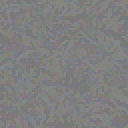
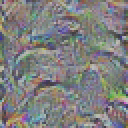
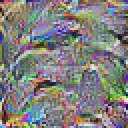
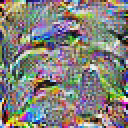
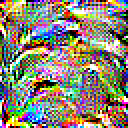
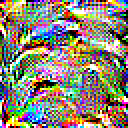

In [164]:
show_result_html(imgs, thresholds)

### Target Layer
target_layer is one of the layers of Inception model

btw, in branch3 they have 3x3 convolution instead of 5x5 -- it's a <a href="https://github.com/pytorch/vision/issues/906">known bug</a> (:

In [262]:
target_layer

Inception(
  (branch1): BasicConv2d(
    (conv): Conv2d(512, 160, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(160, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (branch2): Sequential(
    (0): BasicConv2d(
      (conv): Conv2d(512, 112, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(112, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicConv2d(
      (conv): Conv2d(112, 224, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(224, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (branch3): Sequential(
    (0): BasicConv2d(
      (conv): Conv2d(512, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicConv2d(
      (conv): Conv2d(24, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): B

# Feature Visualization with L1 + Total Variation + Blur

In [80]:
import torch.nn.functional as F

def total_variation(img):
     bs_img, c_img, h_img, w_img = img.size()
     tv_h = torch.sum(torch.abs(img[:,:,1:,:]-img[:,:,:-1,:]))
     tv_w = torch.sum(torch.abs(img[:,:,:,1:]-img[:,:,:,:-1]))
     return (tv_h+tv_w)/(bs_img*c_img*h_img*w_img)

def l1_reg(img, constant=0.5):
    return torch.mean(torch.abs(img - constant))

def blur_reg(x, w=3):
    depth = x.shape[1]  # Depth is channel dimension in PyTorch
    k = np.zeros((depth, 1, w, w))
    for ch in range(depth):
        k_ch = k[ch, 0]
        k_ch[:, :] = 0.5
        k_ch[1:-1, 1:-1] = 1.0
    
    k = torch.from_numpy(k).float().to(x.device)
    
    def conv_k(t):
        return F.conv2d(t, k, padding=w//2, groups=depth)
    
    blurred = conv_k(x) / conv_k(torch.ones_like(x))
    return 0.5 * torch.sum((x - blurred.detach()) ** 2)

def visualize_tv(_image, _transform, tv_strength=0.25, l1_strength=0.05, blur_strength=0.1):
    image_torch = _image()
    model(image_torch)
    activation_loss = -activation['target'][:, local_target_channel].mean()
    tv_loss = total_variation(image_torch)
    l1_loss = l1_reg(image_torch)
    blur_loss = blur_reg(image_torch)
    
    loss = activation_loss + tv_strength * tv_loss + l1_strength * l1_loss + blur_strength * blur_loss
    loss.backward()
    return loss.item()

In [165]:
parameterized_image_tv = ParameterizedImage(image_size, sd=0.1).to(device)
optimizer_tv = torch.optim.Adam(parameterized_image_tv.parameters(), lr=learning_rate)

# obtain ready-to-display feature visualizations
imgs_tv = render_vis(parameterized_image_tv, optimizer_tv, thresholds, visualize_tv)

Iteration 0, Loss: 5.948629856109619
Iteration 100, Loss: -4.555224418640137
Iteration 200, Loss: -5.007221698760986
Iteration 300, Loss: -5.189150810241699
Iteration 400, Loss: -5.251447677612305
Iteration 500, Loss: -5.309947967529297
Iteration 600, Loss: -5.375526428222656
Iteration 700, Loss: -5.400675296783447
Iteration 800, Loss: -5.453423023223877
Iteration 900, Loss: -5.513601303100586
Iteration 1000, Loss: -5.584106922149658
Iteration 1100, Loss: -5.6364850997924805
Iteration 1200, Loss: -5.673755645751953
Iteration 1300, Loss: -5.717860221862793
Iteration 1400, Loss: -5.729687690734863
Iteration 1500, Loss: -5.741312026977539
Iteration 1600, Loss: -5.77020263671875
Iteration 1700, Loss: -5.795751571655273
Iteration 1800, Loss: -5.806358337402344
Iteration 1900, Loss: -5.811227798461914
Iteration 2000, Loss: -5.816122531890869
Iteration 2100, Loss: -5.8368821144104
Iteration 2200, Loss: -5.8224945068359375
Iteration 2300, Loss: -5.824576377868652
Iteration 2400, Loss: -5.83597


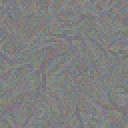
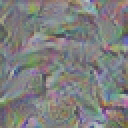
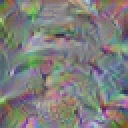
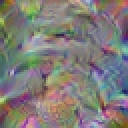
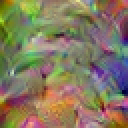
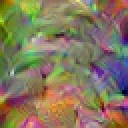

In [166]:
show_result_html(imgs_tv, thresholds)

# Transformation Robustness

In [185]:
def visualize_tr(_image, _transform, tv_strength=0.25, l1_strength=0.05, blur_strength=0.1):
    if isinstance(_image, torch.Tensor):
        image_torch = _image
    else:
        image_torch = _image()
    
    # Apply transformations
    transformed_image = _transform(image_torch)
    
    # Forward pass
    model(transformed_image)
    
    activation_loss = -activation['target'][0, local_target_channel].mean()
    # tv_loss = total_variation(image_torch)
    # l1_loss = l1_reg(image_torch)
    # blur_loss = blur_reg(image_torch)
    
    loss = activation_loss #+ tv_strength * tv_loss + l1_strength * l1_loss + blur_strength * blur_loss
    loss.backward()
    return loss.item()

In [201]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import torchvision.transforms as transforms


random.seed(0)

class TransformationRobustness(nn.Module):
    def __init__(self, pad_size=16, pad_mode='reflect', jitter_size=16, scale_factors=None, angles=None):
        super(TransformationRobustness, self).__init__()
        if angles is None:
            angles = [-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5]
        if scale_factors is None:
            scale_factors = [1, 0.975, 1.025, 0.95, 1.05]
        self.pad_size = pad_size
        self.pad_mode = pad_mode
        self.jitter_size = jitter_size
        self.scale_factors = scale_factors
        self.angles = angles



    def forward(self, x):
        # Apply padding
        x = self._pad_image(x)
        
        x = self._jitter(x)
        
        x = self._random_scale(x)
        
        x = self._random_rotate(x)
        
        x = self._jitter(x, self.jitter_size // 2)
        
        x = self._crop_padding(x)
        
        return x

    def _pad_image(self, x):
        padding = (self.pad_size, self.pad_size, self.pad_size, self.pad_size)
        return F.pad(x, padding, mode=self.pad_mode)
    
    def _jitter(self, x, jitter_size=None):
        if jitter_size is None:
            jitter_size = self.jitter_size
        batch_size, channels, height, width = x.size()
        crop_height = height - jitter_size
        crop_width = width - jitter_size

        top = torch.randint(0, jitter_size + 1, (batch_size,))
        left = torch.randint(0, jitter_size + 1, (batch_size,))

        crops = []
        for i in range(batch_size):
            crop = x[i:i+1, :, top[i]:top[i]+crop_height, left[i]:left[i]+crop_width]
            crops.append(crop)

        return torch.cat(crops, dim=0)
    
    def _random_scale(self, x):
        scale = random.choice(self.scale_factors)
        
        batch_size, channels, height, width = x.size()
        new_height = int(height * scale)
        new_width = int(width * scale)
        
        # Use F.interpolate for scaling
        x_scaled = F.interpolate(x, size=(new_height, new_width), mode='bilinear', align_corners=False)
        
        return x_scaled

    def _random_rotate(self, x):
        angle = random.choice(self.angles)
        
        # Convert angle to radians
        angle_rad = torch.tensor(angle * (3.14159 / 180))
        
        batch_size, channels, height, width = x.size()
        
        # Create rotation matrix
        rot_mat = torch.tensor([
            [torch.cos(angle_rad), -torch.sin(angle_rad), 0],
            [torch.sin(angle_rad), torch.cos(angle_rad), 0]
        ], dtype=x.dtype, device=x.device).unsqueeze(0).repeat(batch_size, 1, 1)
        
        # Create grid
        grid = F.affine_grid(rot_mat, x.size(), align_corners=False)
        
        # Apply rotation
        x_rotated = F.grid_sample(x, grid, align_corners=False, mode='bilinear')
        
        return x_rotated
    
    def _crop_padding(self, x):
        """
        Crop the padding added to the image.
        
        Args:
        x (torch.Tensor): Input tensor of shape (batch_size, channels, height, width)
        
        Returns:
        torch.Tensor: Cropped tensor with padding removed
        """
        if self.pad_size == 0:
            return x
        
        _, _, height, width = x.size()
        return x[:, :, self.pad_size:height-self.pad_size, self.pad_size:width-self.pad_size]

torch.Size([1, 4, 298, 300])


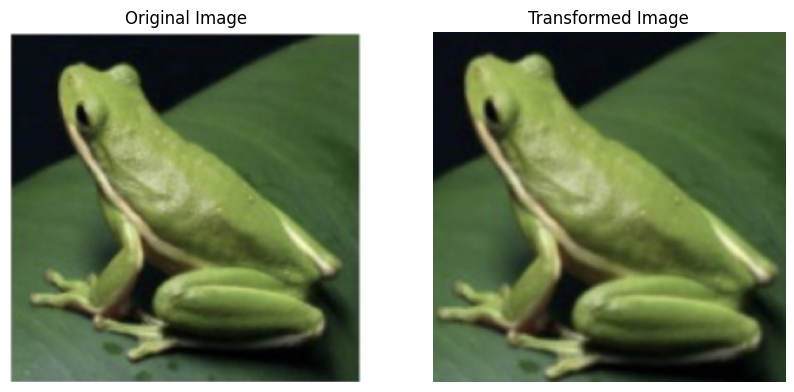

In [202]:
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

# Assuming TransformationRobustness is defined as in the previous artifact

def test_transformation_robustness():
    # Load a sample image
    image_path = "/Users/max/Desktop/frog.png"  # Replace with your image path
    image = Image.open(image_path)
    
    # Convert the image to a PyTorch tensor
    to_tensor = transforms.ToTensor()
    image_tensor = to_tensor(image).unsqueeze(0)  # Add batch dimension
    print(image_tensor.shape)
    # Create an instance of TransformationRobustness
    transform = TransformationRobustness(pad_size=16, pad_mode='reflect')
    
    # Apply the transformations
    transformed_tensor = transform(image_tensor)
    
    # Convert tensors back to images for visualization
    to_pil = transforms.ToPILImage()
    original_image = to_pil(image_tensor.squeeze(0))
    transformed_image = to_pil(transformed_tensor.squeeze(0))
    
    # Visualize the results
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    ax1.imshow(original_image)
    ax1.set_title("Original Image")
    ax1.axis('off')
    ax2.imshow(transformed_image)
    ax2.set_title("Transformed Image")
    ax2.axis('off')
    plt.show()

# Run the test
test_transformation_robustness()

In [203]:
transform = TransformationRobustness().to(device)
parameterized_image_tr = ParameterizedImage(image_size, sd=0.01).to(device)
optimizer_tr = torch.optim.Adam(parameterized_image_tr.parameters(), lr=learning_rate)

# obtain ready-to-display feature visualizations
imgs_tr = render_vis(parameterized_image_tr, optimizer_tr, thresholds, visualize_tr, transform)

Iteration 0, Loss: 3.888218402862549
Iteration 100, Loss: -0.758978009223938
Iteration 200, Loss: -0.8590859174728394
Iteration 300, Loss: -1.369502305984497
Iteration 400, Loss: -2.106564521789551
Iteration 500, Loss: -2.085862874984741
Iteration 600, Loss: -2.3089911937713623
Iteration 700, Loss: -2.3499643802642822
Iteration 800, Loss: -1.2824105024337769
Iteration 900, Loss: -2.3818719387054443
Iteration 1000, Loss: -2.8014719486236572
Iteration 1100, Loss: -2.575993537902832
Iteration 1200, Loss: -0.9266275763511658
Iteration 1300, Loss: -2.923656463623047
Iteration 1400, Loss: -2.131885051727295
Iteration 1500, Loss: -2.3893702030181885
Iteration 1600, Loss: -2.705674886703491
Iteration 1700, Loss: -1.9390360116958618
Iteration 1800, Loss: -1.3340896368026733
Iteration 1900, Loss: -3.4588863849639893
Iteration 2000, Loss: -2.8696587085723877
Iteration 2100, Loss: -1.9866420030593872
Iteration 2200, Loss: -2.8908023834228516
Iteration 2300, Loss: -2.8586175441741943
Iteration 2400


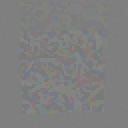
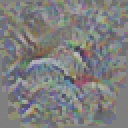
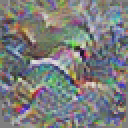
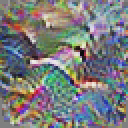
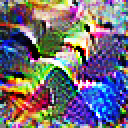
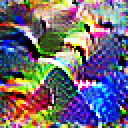

In [204]:
show_result_html(imgs_tr, thresholds)

# Decorrelated Space (Preconditioning) + TR

In [173]:
import numpy as np

np.random.seed(0)

def get_fft_scale(shape, decay_power=1):
    freqs = np.fft.fftfreq(shape[-1])[:, None] ** 2 + np.fft.fftfreq(shape[-2])[None, :] ** 2
    return (1 + freqs) ** (-decay_power / 2)

def to_decorrelated_space(image, decay_power=1):
    scale = get_fft_scale(image.shape[-2:], decay_power)
    scale = torch.from_numpy(scale).float().to(image.device)
    
    fft_img = torch.fft.rfft2(image)
    return torch.fft.irfft2(fft_img * scale[None, None, :, :fft_img.shape[-1]])

def from_decorrelated_space(image, decay_power=1):
    scale = get_fft_scale(image.shape[-2:], decay_power)
    scale = torch.from_numpy(scale).float().to(image.device)
    
    fft_img = torch.fft.rfft2(image)
    return torch.fft.irfft2(fft_img / scale[None, None, :, :fft_img.shape[-1]])

In [178]:
def render_vis_ds_tr(_image, _optimizer, _thresholds, _visualize, _transform, **_visualize_params):
    images = []
    for i in range(num_iterations + 1):
        _optimizer.zero_grad()
        decor_image = from_decorrelated_space(_image(), 1)
        loss = _visualize(decor_image, _transform, **_visualize_params)
        _optimizer.step()
        
        with torch.no_grad():
            _image().data.copy_(to_decorrelated_space(decor_image, 1))
        
        if i % 100 == 0:
            print(f"Iteration {i}, Loss: {loss}")
        
        if i in _thresholds:
            img_np = (_image()
                      .squeeze() # remove batch dimension
                      .detach() # detach from graph (will not be included in autograd and never require the gradient) 
                      .cpu() # from mps/cuda -> cpu
                      .numpy() # to numpy array instead of pytorch.Tensor
                      )
            images.append(img_np)
    
    return images    

In [188]:
parameterized_image_ds = ParameterizedImage(image_size, sd=0.1).to(device)
optimizer_ds = torch.optim.Adam(parameterized_image_ds.parameters(), lr=learning_rate)


# obtain ready-to-display feature visualizations
imgs_ds = render_vis_ds_tr(parameterized_image_ds, optimizer_ds, thresholds, visualize_tr, transform, tv_strength=0.15, blur_strength=0.01)

Iteration 0, Loss: 3.899481773376465
Iteration 100, Loss: -0.9753473401069641
Iteration 200, Loss: -0.9021841287612915
Iteration 300, Loss: -0.7824930548667908
Iteration 400, Loss: -0.9299214482307434
Iteration 500, Loss: -2.4632720947265625
Iteration 600, Loss: -1.040233850479126
Iteration 700, Loss: -2.853126287460327
Iteration 800, Loss: -2.5465281009674072
Iteration 900, Loss: -1.7829424142837524
Iteration 1000, Loss: -3.338771343231201
Iteration 1100, Loss: -2.1367735862731934
Iteration 1200, Loss: -3.1934454441070557
Iteration 1300, Loss: -1.644160270690918
Iteration 1400, Loss: -2.9003586769104004
Iteration 1500, Loss: -1.956991195678711
Iteration 1600, Loss: -1.8228756189346313
Iteration 1700, Loss: -3.3545379638671875
Iteration 1800, Loss: -3.080226182937622
Iteration 1900, Loss: -2.614546060562134
Iteration 2000, Loss: -0.7963061332702637
Iteration 2100, Loss: -3.374119758605957
Iteration 2200, Loss: -2.71297025680542
Iteration 2300, Loss: -2.9281535148620605
Iteration 2400, 


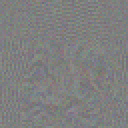
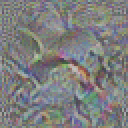
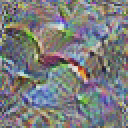
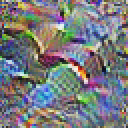
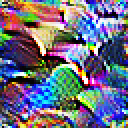
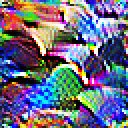

In [189]:
show_result_html(imgs_ds, thresholds)

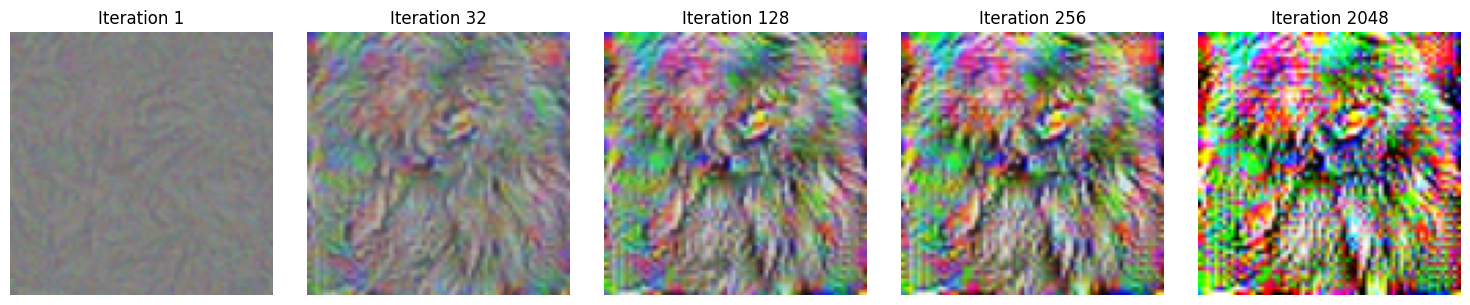

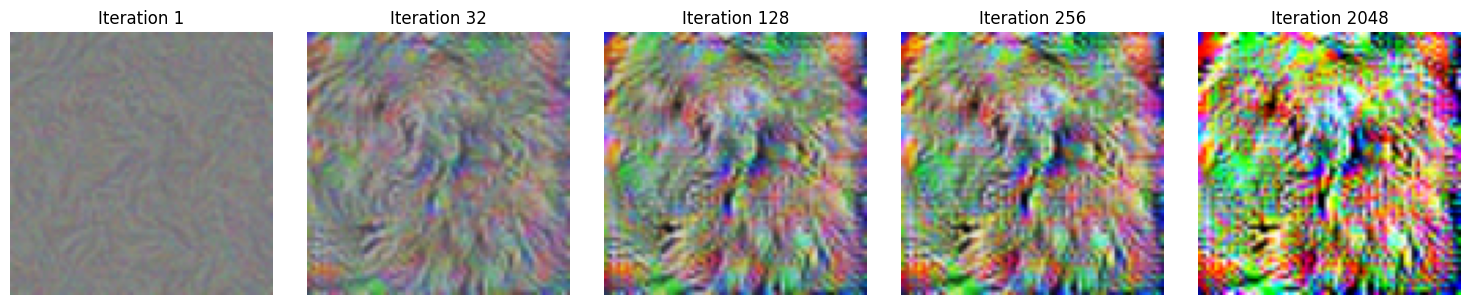

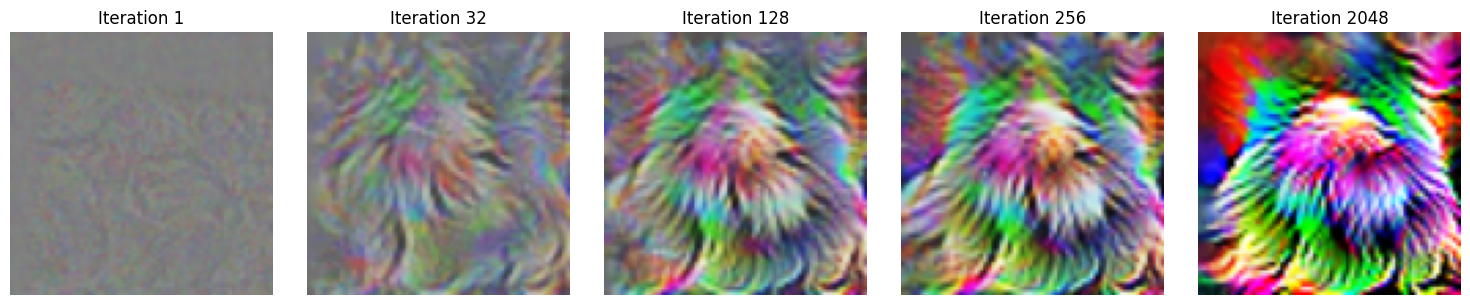

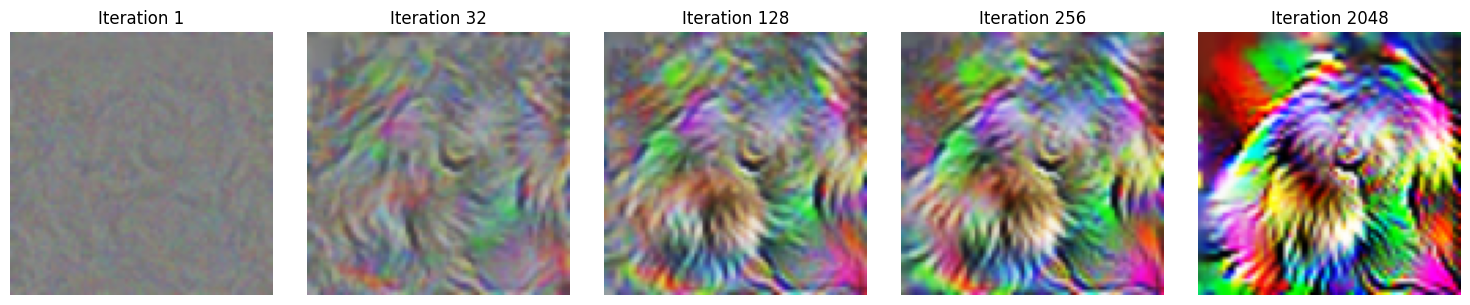

In [312]:
# FINAL RESULTS
show_result(imgs, thresholds)
show_result(imgs_tv, thresholds)
show_result(imgs_tr, thresholds)
show_result(imgs_ds, thresholds)


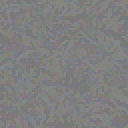
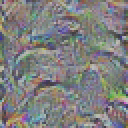
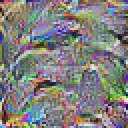
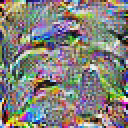
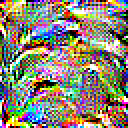
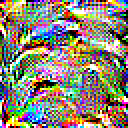


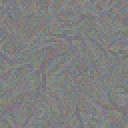
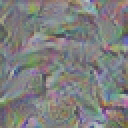
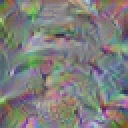
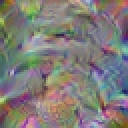
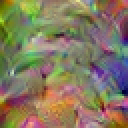
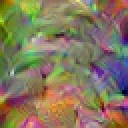


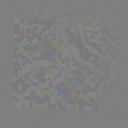
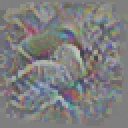
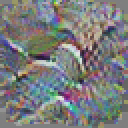
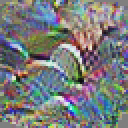
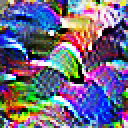
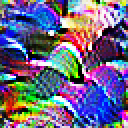


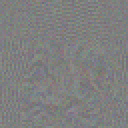
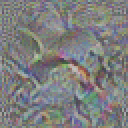
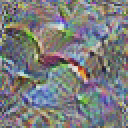
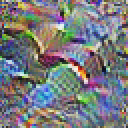
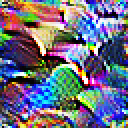
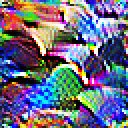

In [193]:
show_result_html(imgs, thresholds)
show_result_html(imgs_tv, thresholds)
show_result_html(imgs_tr, thresholds)
show_result_html(imgs_ds, thresholds)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0476193].


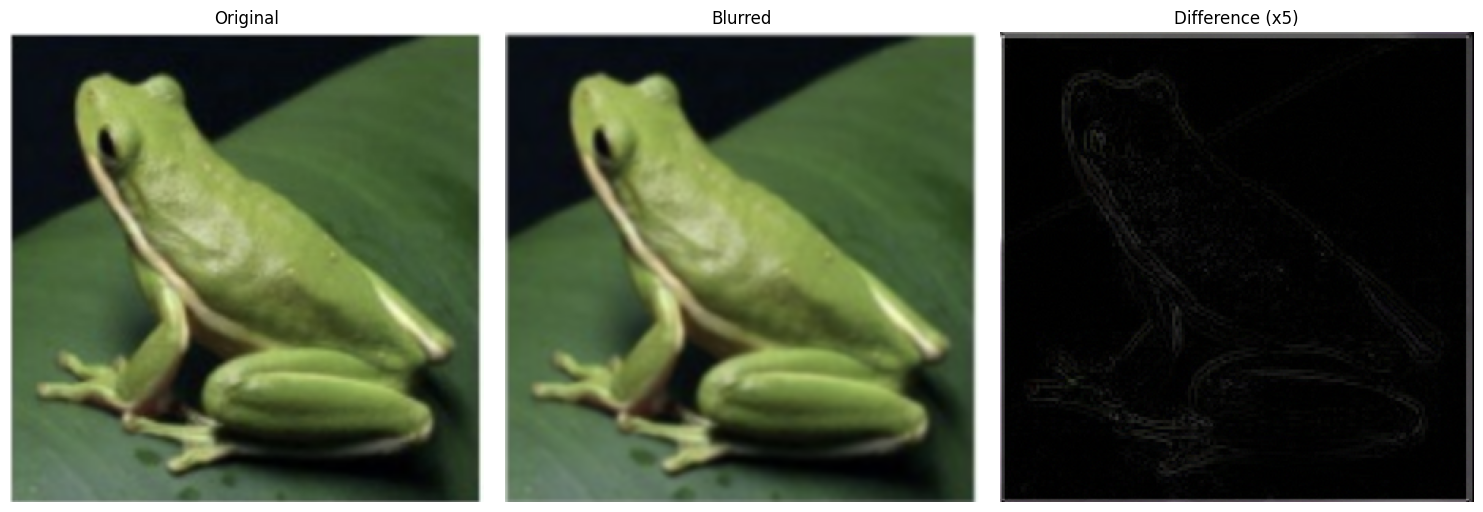

Blur regularization loss: 38.25677490234375


In [342]:
import torch
import torch.nn.functional as F
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Load the image
image_path = "/Users/max/Desktop/frog.png"
image = Image.open(image_path).convert('RGB')

# Convert to PyTorch tensor and normalize
image_tensor = torch.from_numpy(np.array(image)).float().permute(2, 0, 1).unsqueeze(0)
image_tensor /= 255.0

# Apply blur_reg
loss, blurred = blur_reg(image_tensor)

# Convert tensors back to numpy arrays for plotting
original_np = image_tensor.squeeze(0).permute(1, 2, 0).numpy()
blurred_np = blurred.squeeze(0).permute(1, 2, 0).detach().numpy()
difference_np = np.abs(original_np - blurred_np)

# Plot the results
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

ax1.imshow(original_np)
ax1.set_title('Original')
ax1.axis('off')

ax2.imshow(blurred_np)
ax2.set_title('Blurred')
ax2.axis('off')

ax3.imshow(difference_np * 5)  # Multiply by 5 to make the difference more visible
ax3.set_title('Difference (x5)')
ax3.axis('off')

plt.tight_layout()
plt.show()

print(f"Blur regularization loss: {loss.item()}")